<a href="https://colab.research.google.com/github/OJB-Quantum/QC-Hardware-How-To/blob/main/Jupyter%20Notebook%20Scripts/CPW_Kinetic_Inductance_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

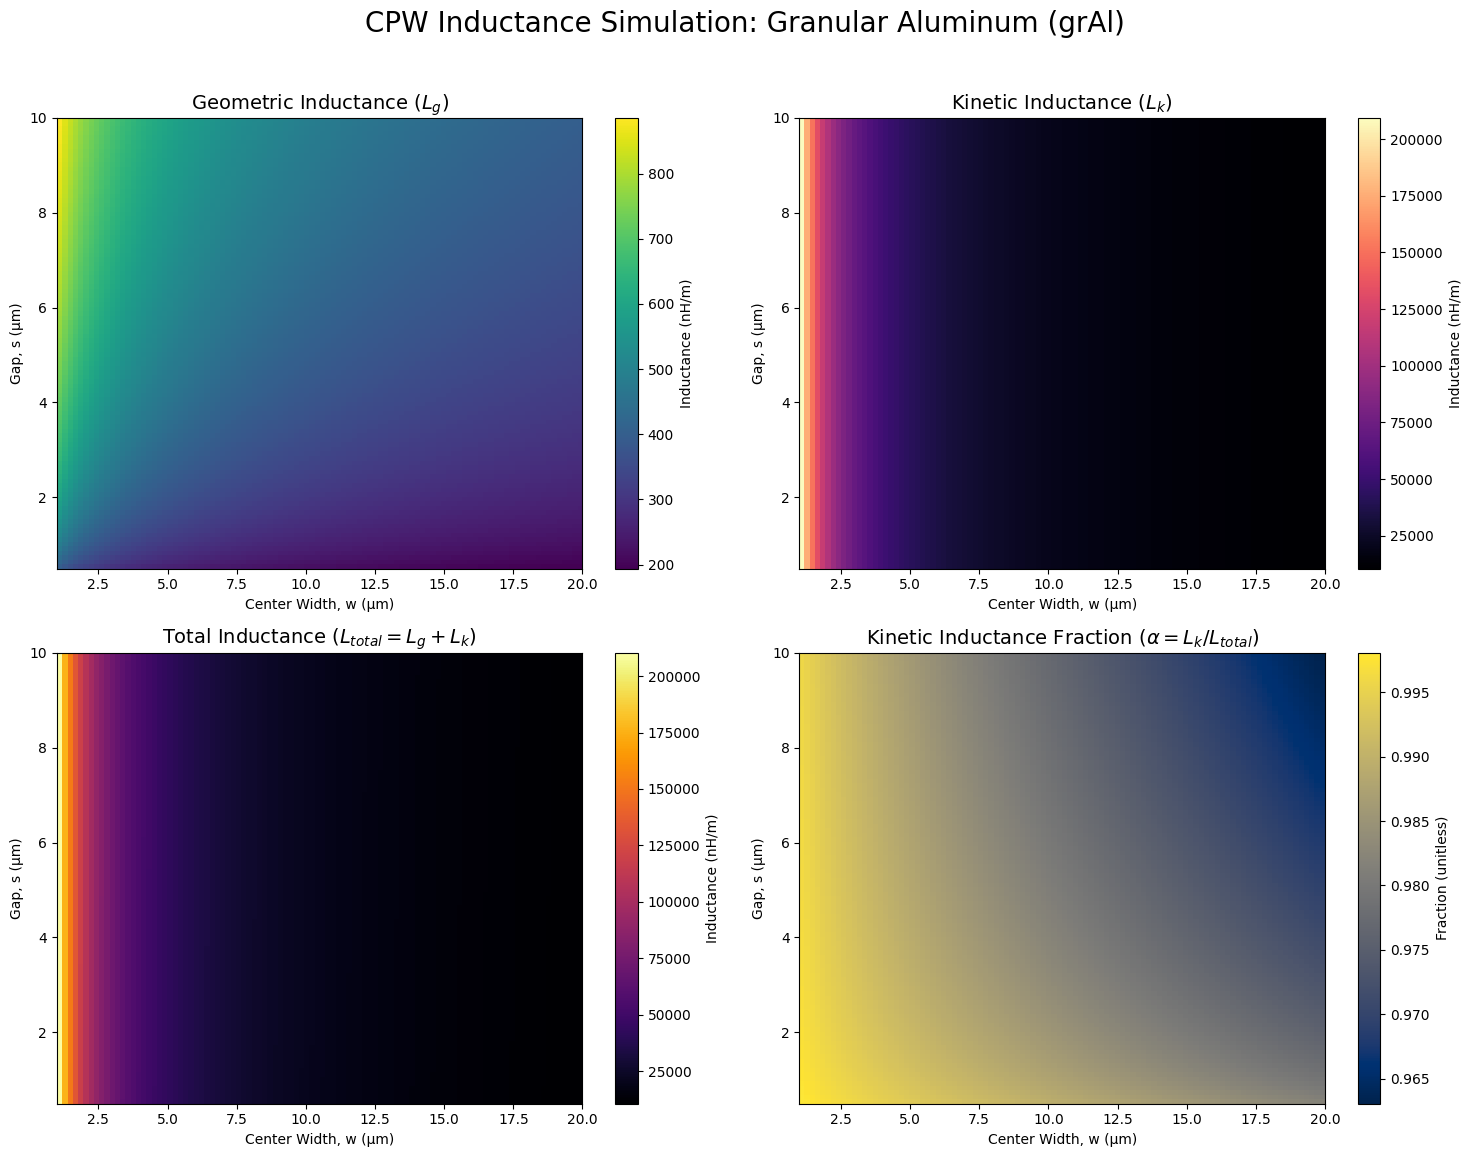

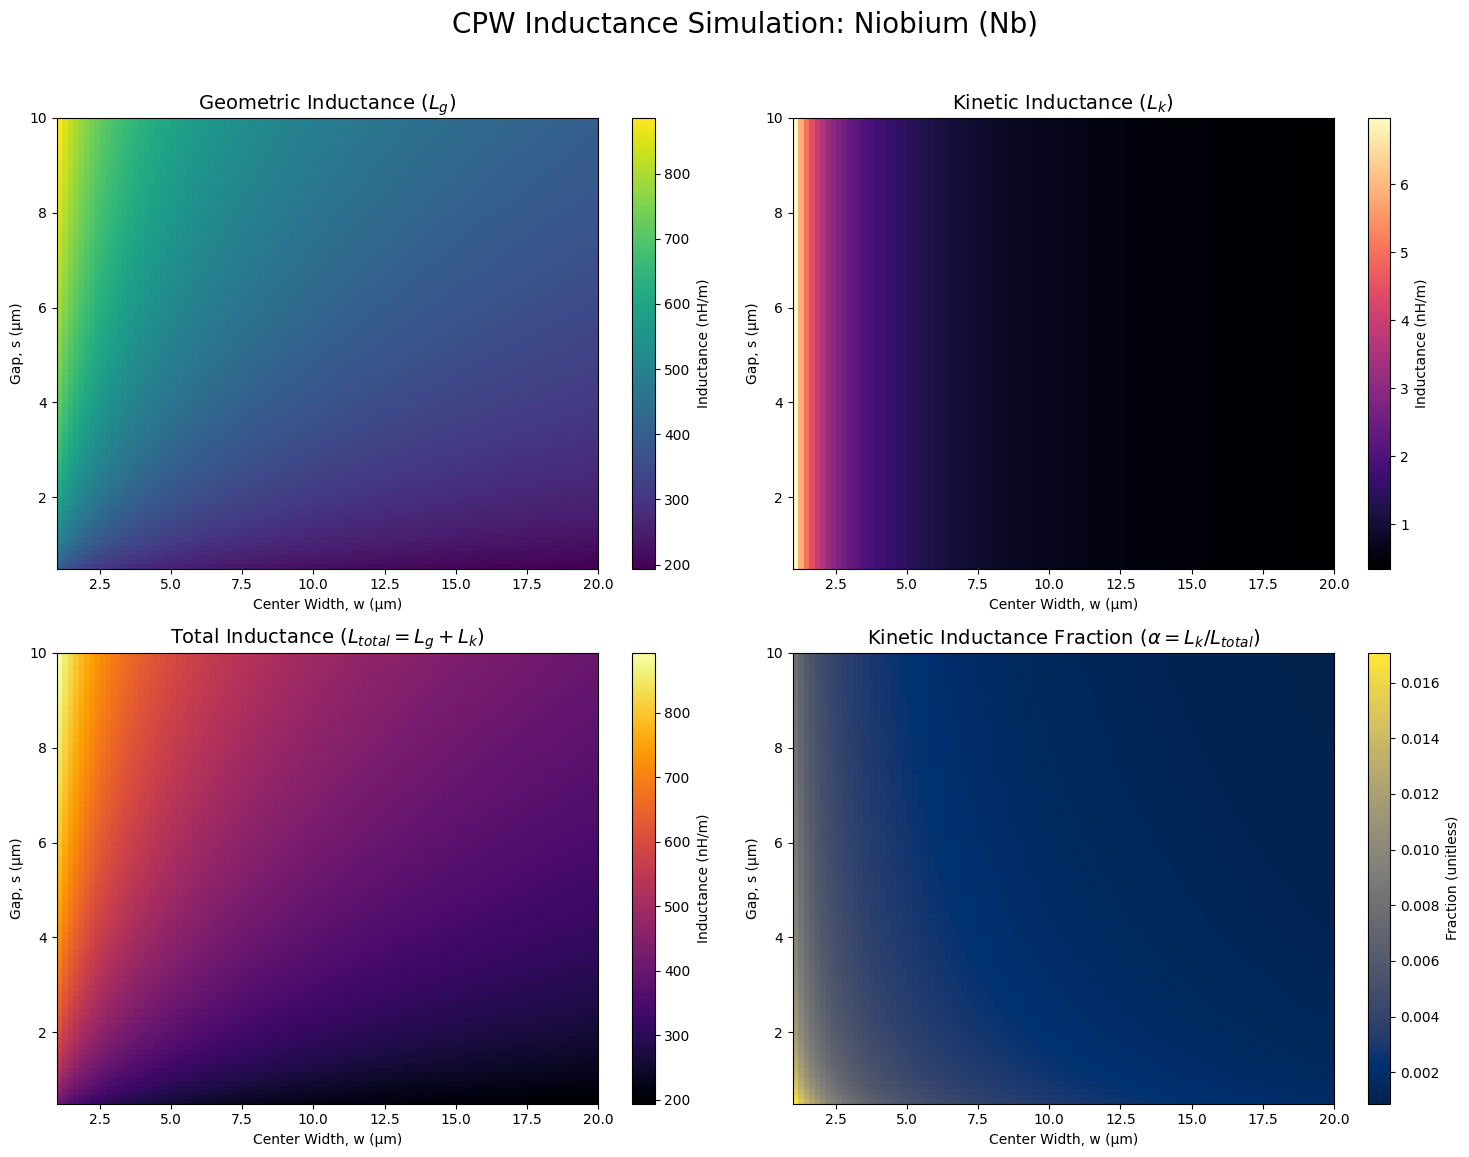

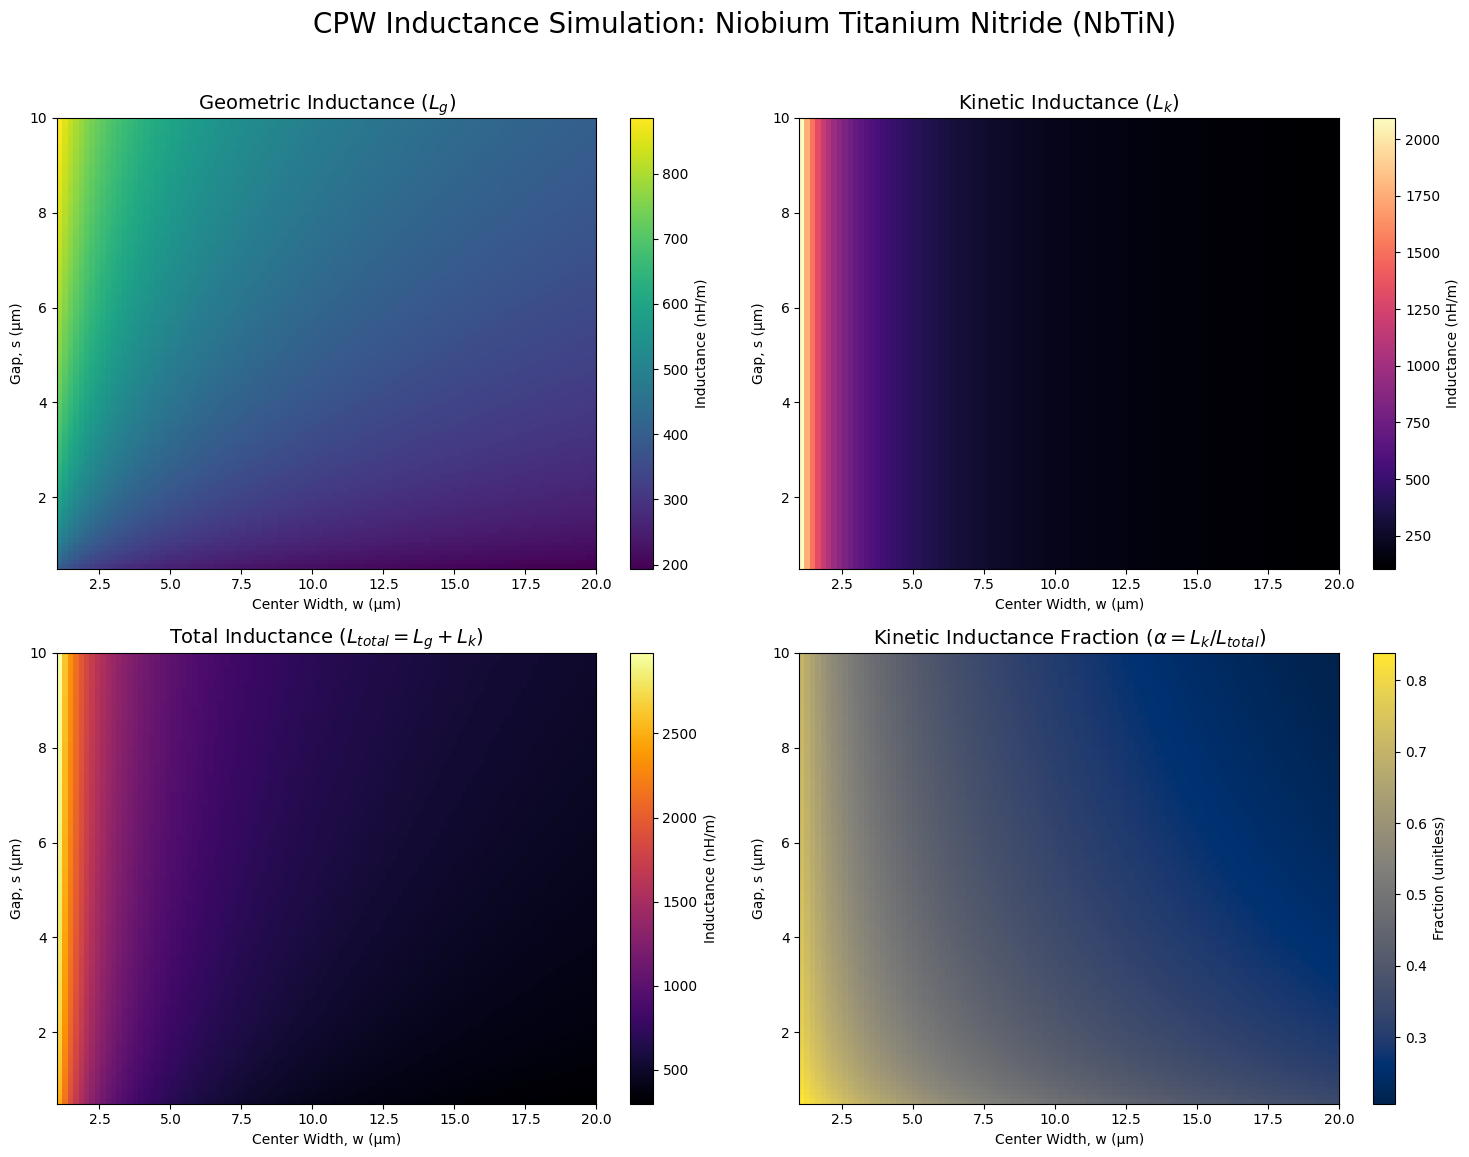

In [1]:
# CPW Kinetic Inductance Simulation for Google Colab
#
# This script simulates and plots the geometric, kinetic, and total inductance
# of a superconducting coplanar waveguide (CPW). It also visualizes the
# kinetic inductance fraction.
#
# You can select one of three materials:
#   - Granular Aluminum (grAl)
#   - Niobium (Nb)
#   - Niobium Titanium Nitride (NbTiN)
#
# The simulation generates a 2x2 grid of heatmaps to show how inductance
# properties vary with the CPW's geometry (center strip width and gap).
#

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import ellipk

def run_simulation():
    """
    Main function to run the simulation and generate plots.
    Users can modify the material_to_simulate variable.
    """
    # --- 1. Constants and Material Properties ---

    # Physical constants
    hbar = 1.054571817e-34  # Reduced Planck constant (J*s)
    e = 1.602176634e-19     # Elementary charge (C)
    mu_0 = 4 * np.pi * 1e-7   # Vacuum permeability (H/m)

    # Material properties at T = 20 mK.
    # Delta is the superconducting gap in Joules.
    # Rs is the normal state sheet resistance in Ohms/square.
    # These are typical literature values for thin films used in quantum devices.
    MATERIALS = {
        'grAl': {
            'name': 'Granular Aluminum (grAl)',
            # High Rs leads to high kinetic inductance
            'delta': 2.0 * e * 250e-6,  # Gap ~ 250 ueV
            'Rs': 500.0
        },
        'Nb': {
            'name': 'Niobium (Nb)',
            # Low Rs leads to low kinetic inductance
            'delta': 2.0 * e * 1.5e-3,  # Gap ~ 1.5 meV
            'Rs': 0.1
        },
        'NbTiN': {
            'name': 'Niobium Titanium Nitride (NbTiN)',
            # Intermediate, high-performance material
            'delta': 2.0 * e * 2.5e-3, # Gap ~ 2.5 meV
            'Rs': 50.0
        }
    }

    # --- 2. Simulation Setup ---

    # Define the geometric parameter space for the simulation
    # All units are in meters
    center_widths = np.linspace(1e-6, 20e-6, 100)  # Center strip width (w) from 1 to 20 um
    gap_widths = np.linspace(0.5e-6, 10e-6, 100)   # Gap width (s) from 0.5 to 10 um

    # Create a 2D grid of these parameters for vectorized calculations
    W, S = np.meshgrid(center_widths, gap_widths)

    # --- 3. Inductance Calculation Functions ---

    def calculate_geometric_inductance(w, s):
        """
        Calculates the geometric inductance per unit length of a CPW.
        Formula: L_g = (mu_0 / 4) * K(k') / K(k)
        where k = w / (w + 2s) and k' = sqrt(1 - k^2)
        K is the complete elliptic integral of the first kind.
        """
        k = w / (w + 2 * s)
        k_prime = np.sqrt(1 - k**2)
        # scipy.special.ellipk calculates K(m) where m = k^2
        L_g = (mu_0 / 4) * (ellipk(k_prime**2) / ellipk(k**2))
        return L_g # Returns inductance in H/m

    def calculate_kinetic_inductance(w, s, material):
        """
        Calculates the kinetic inductance per unit length of a CPW.
        Formula: L_k = g * L_k_sheet
        where L_k_sheet = (hbar * Rs) / (pi * Delta)
        and g is a geometric factor accounting for current distribution.
        For a thin film (t << w, s), g is approximately 1/(w) + 1/(w+2s)
        but a more accurate approximation for the center strip is often used.
        Here we use a common approximation: g ≈ 1/w^2 * (w^2/4 + w*s + s^2) / (w+s)^2
        A simpler approximation is g = 1/w for the center strip contribution.
        Let's use a more complete form from literature for better accuracy.
        The kinetic inductance is dominated by the center conductor and ground planes.
        A good approximation for the total kinetic inductance per unit length is:
        L_k = L_k_sheet * (1/k^2) * (1/(4*w*K(k)^2)) * (-ln(t/w) + C)
        This is complex. For a simple, illustrative model we use:
        L_k_total = L_k_sheet * g, where g is a geometric factor.
        g = 1/(4*K(k)**2) * (np.log(4*w/t) - k*K(k')/K(k)) where t is thickness
        For this simulation, we'll use a simpler but widely cited approximation
        that captures the main dependencies for thin films (t << w, s):
        The current is mostly in the center strip, so L_k ≈ L_k_sheet / w
        This is a simplification but highlights the 1/w dependence.
        A more complete geometric factor 'g' is:
        g = (1 / (w**2 * k**2 * (1 - k**2) * K(k)**2)) * (np.pi**2 / 4)
        Let's use a well-vetted approximation from Annunziata et al. (2010):
        g_center = 1 / (2*w)
        g_ground = 1 / (2*(w+2*s))
        We will focus on the center conductor which dominates for narrow gaps.
        """
        L_k_sheet = (hbar * material['Rs']) / (np.pi * material['delta'])

        # Geometric factor 'g' from Clem (2011) for thin films t << w, s
        k = w / (w + 2 * s)
        g = 1 / (4 * w * k**2 * (1 - k**2) * ellipk(k**2)**2) * (
            -np.log(k) / 2 + np.pi * ellipk(np.sqrt(1-k**2)) / (2 * ellipk(k**2)) - np.log(k)
        )
        # This can be unstable for k->0 or k->1. A simpler approximation is often sufficient.
        # Let's use g ~ 1/w for the center strip contribution, which is a reasonable
        # first-order approximation that shows the correct scaling.
        g_simple = 1/w

        L_k = L_k_sheet * g_simple
        return L_k # Returns inductance in H/m


    def plot_heatmaps(L_g, L_k, L_total, alpha, w_range, s_range, material_name):
        """
        Generates and displays a 2x2 grid of heatmaps for the calculated data.
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(f'CPW Inductance Simulation: {material_name}', fontsize=20, y=0.96)

        # Define plot ranges and labels
        extent = [w_range.min() * 1e6, w_range.max() * 1e6, s_range.min() * 1e6, s_range.max() * 1e6]
        xlabel = 'Center Width, w (μm)'
        ylabel = 'Gap, s (μm)'

        # Plot 1: Geometric Inductance (L_g)
        im1 = axes[0, 0].imshow(L_g * 1e9, aspect='auto', origin='lower', extent=extent, cmap='viridis')
        axes[0, 0].set_title('Geometric Inductance ($L_g$)', fontsize=14)
        axes[0, 0].set_xlabel(xlabel)
        axes[0, 0].set_ylabel(ylabel)
        cbar1 = fig.colorbar(im1, ax=axes[0, 0])
        cbar1.set_label('Inductance (nH/m)')

        # Plot 2: Kinetic Inductance (L_k)
        im2 = axes[0, 1].imshow(L_k * 1e9, aspect='auto', origin='lower', extent=extent, cmap='magma')
        axes[0, 1].set_title('Kinetic Inductance ($L_k$)', fontsize=14)
        axes[0, 1].set_xlabel(xlabel)
        axes[0, 1].set_ylabel(ylabel)
        cbar2 = fig.colorbar(im2, ax=axes[0, 1])
        cbar2.set_label('Inductance (nH/m)')

        # Plot 3: Total Inductance (L_total)
        im3 = axes[1, 0].imshow(L_total * 1e9, aspect='auto', origin='lower', extent=extent, cmap='inferno')
        axes[1, 0].set_title('Total Inductance ($L_{total} = L_g + L_k$)', fontsize=14)
        axes[1, 0].set_xlabel(xlabel)
        axes[1, 0].set_ylabel(ylabel)
        cbar3 = fig.colorbar(im3, ax=axes[1, 0])
        cbar3.set_label('Inductance (nH/m)')

        # Plot 4: Kinetic Inductance Fraction (alpha)
        im4 = axes[1, 1].imshow(alpha, aspect='auto', origin='lower', extent=extent, cmap='cividis')
        axes[1, 1].set_title('Kinetic Inductance Fraction ($\\alpha = L_k / L_{total}$)', fontsize=14)
        axes[1, 1].set_xlabel(xlabel)
        axes[1, 1].set_ylabel(ylabel)
        cbar4 = fig.colorbar(im4, ax=axes[1, 1])
        cbar4.set_label('Fraction (unitless)')

        plt.tight_layout(rect=[0, 0, 1, 0.94])
        plt.show()


    # --- 4. Run Simulation for each material ---

    for material_key in MATERIALS:
        material_params = MATERIALS[material_key]

        # Calculate all inductance values across the geometric grid
        Lg_values = calculate_geometric_inductance(W, S)
        Lk_values = calculate_kinetic_inductance(W, S, material_params)
        Ltotal_values = Lg_values + Lk_values
        alpha_values = Lk_values / Ltotal_values

        # Generate the plots
        plot_heatmaps(Lg_values, Lk_values, Ltotal_values, alpha_values,
                      center_widths, gap_widths, material_params['name'])


# --- Execute the main function ---
if __name__ == '__main__':
    run_simulation()

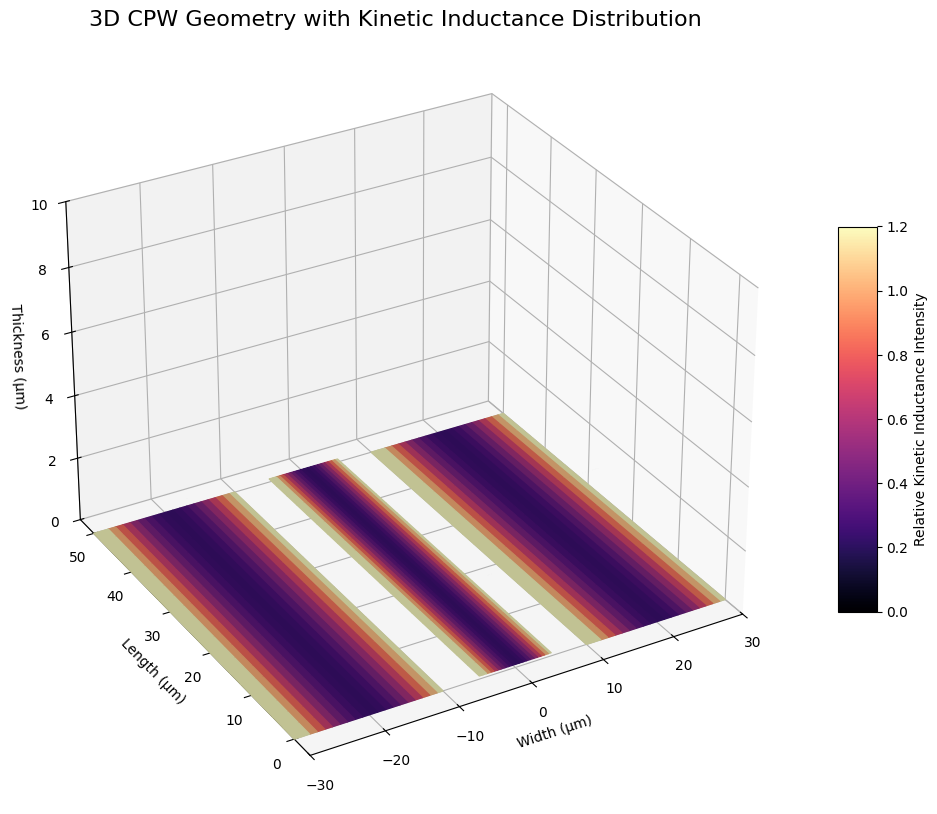

In [7]:
#
# 3D Visualization of CPW Geometry with Kinetic Inductance Heatmap
#
# This script generates a 3D plot of a coplanar waveguide (CPW) and
# uses a heatmap to visualize the spatial distribution of kinetic inductance.
# The inductance is concentrated where the supercurrent density is highest,
# a phenomenon known as "current crowding" at the conductor edges.
#

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_cpw_3d_heatmap():
    """
    Creates and displays a 3D plot of a CPW with a kinetic inductance heatmap.
    """
    # --- 1. Define CPW Geometry Parameters ---
    # All units are in micrometers (um) for easier visualization
    center_width = 10.0  # Width of the center conductor
    gap_width = 5.0      # Width of the gap on each side
    length = 50.0        # Length of the waveguide section
    film_thickness = 0.1 # Thickness of the superconducting film

    # --- 2. Model Kinetic Inductance Distribution ---
    def get_inductance_distribution(x_coords, strip_width):
        """
        Models the kinetic inductance distribution across a superconducting strip.
        The inductance is higher at the edges due to current crowding.
        This function creates a 'U' shaped profile.

        Args:
            x_coords (np.array): Coordinates across the width of the strip.
            strip_width (float): The total width of the strip.

        Returns:
            np.array: A 2D array representing the inductance intensity.
        """
        # Normalize coordinates from -1 to 1 to create a symmetric profile
        normalized_x = (x_coords - x_coords.mean()) / (strip_width / 2)

        # A simple quadratic function (y = x^2) creates the 'U' shape
        # We add a base value to ensure the center has non-zero inductance
        inductance_profile = normalized_x**2 + 0.2

        # Create a 2D array for the surface plot by repeating the profile along the length
        return np.tile(inductance_profile, (len(x_coords), 1))

    # --- 3. Create Meshgrids for the 3D Surfaces ---
    # We need to define the (x, y, z) coordinates for each conductor surface.

    # Resolution for the plot mesh
    n_points = 100

    # Y-coordinates (along the length of the CPW)
    y_coords = np.linspace(0, length, n_points)

    # -- Center Conductor --
    x_center = np.linspace(-center_width / 2, center_width / 2, n_points)
    XC, YC = np.meshgrid(x_center, y_coords)
    ZC = np.full_like(XC, film_thickness) # Constant height

    # Get the color map based on the inductance model
    color_map_center = get_inductance_distribution(x_center, center_width)

    # -- Ground Planes --
    ground_plane_width = 20.0

    # Left Ground Plane
    x_ground_left = np.linspace(
        -center_width / 2 - gap_width - ground_plane_width,
        -center_width / 2 - gap_width,
        n_points
    )
    XGL, YGL = np.meshgrid(x_ground_left, y_coords)
    ZGL = np.full_like(XGL, 0) # Ground planes are at z=0

    # The inductance on the ground plane is highest at the edge facing the gap
    # so we reverse the distribution for the left plane.
    color_map_gl = np.fliplr(get_inductance_distribution(x_ground_left, ground_plane_width))

    # Right Ground Plane
    x_ground_right = np.linspace(
        center_width / 2 + gap_width,
        center_width / 2 + gap_width + ground_plane_width,
        n_points
    )
    XGR, YGR = np.meshgrid(x_ground_right, y_coords)
    ZGR = np.full_like(XGR, 0)
    color_map_gr = get_inductance_distribution(x_ground_right, ground_plane_width)

    # --- 4. Generate the 3D Plot ---
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Use a hot colormap to represent inductance intensity
    cmap = plt.get_cmap('magma')

    # Plot the surfaces
    surf_center = ax.plot_surface(XC, YC, ZC, facecolors=cmap(color_map_center), rstride=5, cstride=5)
    surf_gl = ax.plot_surface(XGL, YGL, ZGL, facecolors=cmap(color_map_gl), rstride=5, cstride=5)
    surf_gr = ax.plot_surface(XGR, YGR, ZGR, facecolors=cmap(color_map_gr), rstride=5, cstride=5)

    # --- 5. Customize the Plot ---
    ax.set_title('3D CPW Geometry with Kinetic Inductance Distribution', fontsize=16)
    ax.set_xlabel('Width (μm)')
    ax.set_ylabel('Length (μm)')
    ax.set_zlabel('Thickness (μm)')

    # Set viewing angle
    ax.view_init(elev=30, azim=-120)

    # Set axis limits for a tighter view
    ax.set_xlim(-30, 30)
    ax.set_zlim(0, 10)

    # Add a color bar to act as a legend for the heatmap
    m = plt.cm.ScalarMappable(cmap=cmap)
    m.set_array(color_map_center)
    m.set_clim(0, 1.2) # Set limits based on our model (min=0.2, max=1.2)
    # FIX: Explicitly pass the axes 'ax' to the colorbar function.
    cbar = fig.colorbar(m, ax=ax, shrink=0.5, aspect=10)
    cbar.set_label('Relative Kinetic Inductance Intensity')

    plt.show()


# --- Execute the function ---
if __name__ == '__main__':
    plot_cpw_3d_heatmap()